In [1]:
#impost libraries
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

%matplotlib inline

In [2]:
# read in the CSV's
calls = pd.read_csv(r'../data/callsForServiceUpdated.csv')

C:\Users\81wingo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean up


In [3]:
calls = calls[calls.rptonly != True]
calls = calls[calls.cancelled != True]
print(len(calls))

1085198


In [4]:
calls['calltime'] = pd.to_datetime(calls.calltime)
calls['year'] = calls.calltime.apply(lambda x: x.date().year)
calls['month'] = calls.calltime.apply(lambda x: x.date().month)
calls['dayOfMonth'] = calls.calltime.apply(lambda x: x.date().day)
calls['hour'] = calls.calltime.apply(lambda x: x.time().hour)
calls = calls.rename(columns={'calldow' : 'dayOfWeek'})
calls = calls.drop(columns = ['timeclose', 'calltime'], axis = 1)
calls

,inci_id,parent_id,case_id,callsource,street,city,streetonly,geox,geoy,nature,...,secsar2lc,secsrt2dsp,secstr2lc,firstdisp,long,lat,year,month,dayOfMonth,hour
0,2012324665,NaN,NaN,SELF,OLD RANDLEMAN RD/COLTRANE MILL RD,G,OLD RANDLEMAN RD/COLTRANE MILL RD,1755293.88,800660.13,TRAFFIC STOP,...,651,0,0,S335,-79.826738,35.947098,2012,7,1,0
1,2012324676,NaN,1234238.0,E911,312 MARTIN LUTHER KING JR DR,G,MARTIN LUTHER KING JR DR,1767127.13,843918.75,HEMORRHAGE / LACERATIONS,...,2454,43,965,M261,-79.787921,36.066193,2012,7,1,0
2,2012324686,NaN,NaN,SELF,4525 W WENDOVER AV,G,W WENDOVER AV,1731815.63,838827.63,TRANSPORT TO ANIMAL SHELTER,...,0,0,0,ACO8,-79.907233,36.051380,2012,7,1,0
3,2012324690,NaN,1234239.0,E911,3905 BROOKHOLLOW RD,W,BROOKHOLLOW RD,1808054.75,822506.31,SEIZURES-CONVULSIONS,...,4522,30,3918,M2,-79.648974,36.008188,2012,7,1,0
4,2012324692,2.012325e+09,1206134.0,E911,3905 BROOKHOLLOW RD,W,BROOKHOLLOW RD,1808054.75,822506.31,SEIZURES-CONVULSIONS,...,900,8,0,E44,-79.648974,36.008188,2012,7,1,0
5,2012324697,NaN,1234240.0,E911,5125 MICHAUX RD,G,MICHAUX RD,1744080.88,874458.88,FALLS-BACK INJURIES(TRAUMATIC),...,0,10,0,M241,-79.866796,36.149555,2012,7,1,0
6,2012324704,NaN,1234241.0,E911,1409 DANS RD,G,DANS RD,1778039.38,840417.56,SICK PERSON,...,2295,29,1267,M211,-79.750911,36.056808,2012,7,1,0
7,2012324709,NaN,NaN,SELF,8069 HAW RIVER RD,ST,HAW RIVER RD,1709461.00,897647.69,TRAFFIC STOP,...,112,0,0,S314,-79.984825,36.212362,2012,7,1,0
8,2012324711,NaN,1234242.0,W911,WESTCHESTER DR/N MAIN ST,H,WESTCHESTER DR/N MAIN ST,1697332.38,814158.75,CHEST PAIN,...,2090,17,1323,M221,-80.023017,35.982696,2012,7,1,0
9,2012324715,NaN,NaN,PHONE,8403 MEARS FORK RD,SU,MEARS FORK RD,1759324.13,906703.25,DOMESTIC DISPUTE,...,1109,102,0,S314,-79.816067,36.238478,2012,7,1,0


Drop unnecessary Columns

In [5]:
calls['actualnature'] = [x['nature2'] if x['nature'] is np.nan and x['nature'] != x['nature2'] else x['nature'] for i,x in calls.iterrows()]

In [6]:
calls.columns


Index(['inci_id', 'parent_id', 'case_id', 'callsource', 'street', 'city',
       'streetonly', 'geox', 'geoy', 'nature', 'nature2', 'priority',
       'medprior', 'meddislvl', 'rptonly', 'service', 'agency', 'district',
       'statbeat', 'ra', 'gp', 'primeunit', 'cancelled', 'closecode',
       'dayOfWeek', 'secs2rt', 'secs2di', 'secs2en', 'secs2ar', 'secs2tr',
       'secs2lc', 'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc',
       'secsrt2dsp', 'secstr2lc', 'firstdisp', 'long', 'lat', 'year', 'month',
       'dayOfMonth', 'hour', 'actualnature'],
      dtype='object')

In [7]:
calls.shape

(1085198, 45)

In [8]:
calls.priority.unique()

array(['1', '4', '9', 'P', '3', '2', '7', '5', '8', nan, '6'],
      dtype=object)

There are nan in the set so we need to get rid of those

In [9]:
calls = calls[calls['priority'].notnull()]

In [10]:
#make sure that the nan values are gone
calls.priority.unique()

array(['1', '4', '9', 'P', '3', '2', '7', '5', '8', '6'], dtype=object)

Try to limit to only things an operator would know when recieving the call.

In [11]:
newdf = calls.drop(columns=['inci_id', 'parent_id', 'case_id', 'callsource', 'street', 'city',
       'streetonly', 'geox', 'geoy', 'nature', 'nature2', 'medprior', 'meddislvl', 'rptonly', 'service', 
       'statbeat', 'ra', 'gp', 'primeunit', 'cancelled', 'closecode',
       'dayOfWeek', 'secs2rt', 'secs2di', 'secs2en', 'secs2tr',
       'secs2lc', 'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc',
       'secsrt2dsp', 'secstr2lc', 'firstdisp', 'long', 'lat', 'year', 'month',
       'dayOfMonth', 'hour', 'secs2ar'])

In [12]:
#use sklearn label encoder to convert strings to numbers that can be used for calculations
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in newdf.columns:
    newdf[col] = labelencoder.fit_transform(newdf[col].astype(str))
 
newdf.head(11)

,priority,agency,district,actualnature
0,0,3,58,192
1,3,1,13,126
2,8,0,63,198
3,0,1,11,173
4,9,2,0,173
5,2,1,9,103
6,3,1,4,174
7,0,3,55,192
8,0,1,5,70
9,0,3,55,86


In [13]:
newdf.columns


Index(['priority', 'agency', 'district', 'actualnature'], dtype='object')

In [14]:
newdf.describe()

,priority,agency,district,actualnature
count,1.084954e+06,1.084954e+06,1.084954e+06,1.084954e+06
mean,2.708889e+00,1.797061e+00,3.197515e+01,1.239234e+02
std,2.954226e+00,1.072626e+00,2.335326e+01,6.978734e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,7.000000e+00,6.100000e+01
50%,1.000000e+00,1.000000e+00,3.400000e+01,1.240000e+02
75%,4.000000e+00,3.000000e+00,5.700000e+01,1.920000e+02
max,9.000000e+00,3.000000e+00,6.300000e+01,2.570000e+02


In [15]:
newdf['priority'].value_counts()

0    302044
1    253865
3    130006
2    103999
6    100373
8     78146
9     78126
4     37366
7       995
5        34
Name: priority, dtype: int64

In [16]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [17]:
import statsmodels.formula.api as smf
fitdf= smf.ols(formula = 'priority ~ district + agency + actualnature', data= newdf).fit()
fitdf.params

Intercept       4.117426
district        0.071419
agency         -1.428718
actualnature   -0.009076
dtype: float64

In [18]:
fitdf.rsquared

0.25337851971742276

In [19]:
fitdf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               priority   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                 1.227e+05
Date:                Fri, 30 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:50:02   Log-Likelihood:            -2.5562e+06
No. Observations:             1084954   AIC:                         5.112e+06
Df Residuals:                 1084950   BIC:                         5.113e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.1174      0.007    577.997      0.000       4.103       4.131
district         0.0714      0.000    554.272      0.000       0.071       0.072
agency          -1.4287      0.003   -511.385      0.000      -1.434      -1.423
actualnature    -0.0091   3.85e-05   -235.942      0.000      -0.009      -0.009
==============================================================================
Omnibus:                   109545.235   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145632.853
Skew:                           0.870   Prob(JB):                         0.00
Kurtosis:                       3.437   Cond. No.                         437.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
newdf.head()

,priority,agency,district,actualnature
0,0,3,58,192
1,3,1,13,126
2,8,0,63,198
3,0,1,11,173
4,9,2,0,173


from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X = newdf.iloc[:,1:4]
y = newdf.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = preprocessing.StandardScaler()
X_train=scaler.fit_transform(X_train)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
regression_model.score(X_train, y_train)

**R squared value said that this would not be an accurate, but i wanted a starting point of how good a "bad" model would be**

In [21]:
from sklearn.model_selection import train_test_split
X = newdf.iloc[:,1:6].values
y= newdf.priority


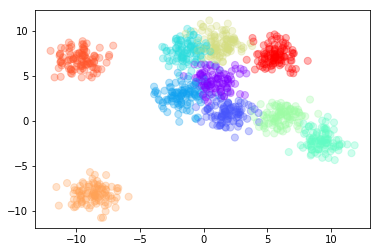

In [22]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=10, n_features=10,
                  random_state=0)
ax= plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', alpha = .3);


In [23]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1:6], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=5)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

In [24]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [25]:
from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in [5, 10, 15, 20]:
# create the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# fit the model
    y_pred_knn=knn.fit(X_train, y_train)
#print each group out 
    print(n_neighbors, knn.score(X_test, y_test))

5 0.9433333333333334
10 0.9566666666666667
15 0.95
20 0.95


It looks like a lower K Neighbor will be more likely to be accurate. So lets try a group of numbers less than 5.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
for n_neighbors in [2, 3, 4, 5]:
# create the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# fit the model
    knn.fit(X_train, y_train)
    y_pred_knn= knn.predict(X_test)
    
#print each group out 
    print(n_neighbors, knn.score(X_test,y_test))

2 0.94
3 0.95
4 0.9533333333333334
5 0.9433333333333334


In [27]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred_knn))  
print(classification_report(y_pred_knn,y_test))  

[[22  0  1  1  0  0  0  0  0  0]
 [ 2 35  0  0  0  1  0  0  0  0]
 [ 1  0 32  0  0  0  0  0  0  0]
 [ 1  0  0 27  0  0  2  0  0  0]
 [ 0  0  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0]
 [ 2  0  0  4  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0  0  0 30  0]
 [ 1  0  0  0  0  0  1  0  0 24]]
             precision    recall  f1-score   support

          0       0.92      0.76      0.83        29
          1       0.92      1.00      0.96        35
          2       0.97      0.97      0.97        33
          3       0.90      0.84      0.87        32
          4       1.00      1.00      1.00        29
          5       1.00      0.96      0.98        26
          6       0.83      0.91      0.87        33
          7       1.00      1.00      1.00        29
          8       1.00      1.00      1.00        30
          9       0.92      1.00      0.96        24

avg / total       0.94      0.94      0.94       300



## K-fold Cross Validation


In [28]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(3), X, y, cv=10)
print(cv)

[0.95 0.96 0.94 0.95 0.93 0.95 0.92 0.92 0.94 0.98]


C:\Users\81wingo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


C:\Users\81wingo\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


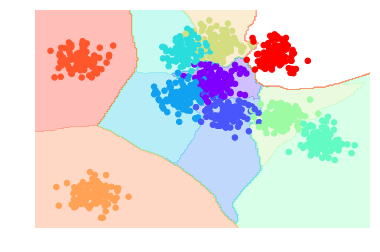

In [29]:
visualize_classifier(KNeighborsClassifier(3), X, y)

In [30]:
cv.mean()

0.944

## PCA Dimensional reduction

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_reduced = pca.transform(X)
prediction =pca.score(X_test,y_test)
print(prediction)

-6.202347158256273


## SVM

from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = newdf.iloc[:,1:4]
y = newdf.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = preprocessing.StandardScaler()
X_train=scaler.fit_transform(X_train)

clf = svm.SVC()
clf.fit(X_train, y_train)

X_test=scaler.fit_transform(X_test)
y_predict=clf.predict(X_test)

from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_predict)
print(score)

**..... ran two days so lets try taking a random sample and seeing how the accuracy is**

In [32]:
sample = newdf.sample(n=100, replace = False)

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = newdf
y = newdf.priority

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = preprocessing.StandardScaler() 
X_train=scaler.fit_transform(X_train)

from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)
 
y_predict=clf.predict(X_test)

 
score=accuracy_score(y_test,y_predict) 
print(score)

The Sample size is so small because when I increased the sample size to 1000 it ran over night and still was unable to finish. With more computing power and time a SVC would be possible.

## Random Forest Classifier

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# use seaborn plotting defaults
import seaborn as sns; sns.set()
X = newdf.iloc[:,1:6].values
y= newdf.priority
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [36]:
#visualize_classifier(DecisionTreeClassifier(), X_train, y_train)

In [37]:
print(tree.score(X_test,y_test,sample_weight=None))

0.8417663378260883


In [38]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, tree.predict(X_test), average='macro'))
print(recall_score(y_test, tree.predict(X_test), average='macro'))

0.8336853126887199
0.8145446545974331


In [39]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#visualize_classifier(clf, X_train, y_train);

C:\Users\81wingo\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [40]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, clf.predict(X_test), average='macro'))
print(recall_score(y_test, clf.predict(X_test), average='macro'))

0.8315493978743962
0.8124651845418833


In [41]:
from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)


0.8413546470365943

##### The K neighbors ended up being the best with 94% but Decision Tree and Random Forest came out to about the same 84%
In the future i would like to go back to this and find the optimal features i picked the ones that i thought would be important and the operator would have when recieving a call.
Also couldn't get the decision tree and random forest to work with the visualize classifer once i made the last changes which fixed the tree algorithms.